In [1]:
from imports import *

## Import data

In [2]:
# Cargar archivo Parquet
table = pq.read_table("v0704_baseline_preproc.parquet")

# Convertir de Arrow Table a awkward Array
data_loaded = {name: ak.from_arrow(column) for name, column in zip(table.column_names, table.columns)}

# Acceder a las variables cargadas
nuvT = data_loaded["nuvT"]
f_ophit_PE = data_loaded["f_ophit_PE"]
f_ophit_ch = data_loaded["f_ophit_ch"]
f_ophit_t = data_loaded["f_ophit_t"]
dEpromx = data_loaded["dEpromx"]
dEpromy = data_loaded["dEpromy"]
dEpromz = data_loaded["dEpromz"]

### Creation of PE matrix

In [3]:
# Create matrices to store the number of photoelectrons and times for each event and channel
pe_matrix = np.zeros((len(f_ophit_ch), 312))

# Populate the matrices
for i in range(len(f_ophit_ch)):
    for j in range(len(f_ophit_ch[i])):
        for k, l in zip(f_ophit_PE[i][j], f_ophit_ch[i][j]):
            pe_matrix[i][l] += k

### Creation of Image

**import maps**

In [7]:
# Load the matrices from CSV files into separate variables
file_names = ["total_map_realistic_flipped", "pmts_map_realistic_flipped", "coated_pmt_map_realistic_flipped", "uncoated_pmt_map_realistic_flipped" ,"xarap_map_realistic_flipped", "xarap_vis_map_realistic_flipped" , "xarap_vuv_map_realistic_flipped", "total_map_compressed", "pmts_map_compressed", "coated_pmt_map_compressed", "uncoated_pmt_map_compressed","xarapucas_map_compressed", "xarap_vis_map_compressed", "xarap_vuv_map_compressed"]

for i, name in enumerate(file_names):
    if 0 <= i < 7:  
        locals()[name] = np.loadtxt(f"saved_archives/maps/realistic/flipped/{name}.csv", delimiter=",", dtype=int)
    else:  
        locals()[name] = np.loadtxt(f"saved_archives/maps/compressed/{name}.csv", delimiter=",", dtype=int)

**sin tiempos**

**si se quiere usar tiempos, usar la función image_creator gen (pe_matrix, time_matrix, maps)**

In [9]:
#funtion image_creator_gen_onlype (in _4_Image_creation_visualization.py)
image_onlype = image_creator_gen_onlype(pe_matrix, coated_pmt_map_realistic_flipped, uncoated_pmt_map_realistic_flipped, xarap_vis_map_realistic_flipped, xarap_vuv_map_realistic_flipped)

### Creación y Normalización de y

In [11]:
dEpromx = np.array(dEpromx).flatten()
dEpromy = np.array(dEpromy).flatten()
dEpromz = np.array(dEpromz).flatten()
dEpromx = dEpromx.reshape(-1, 1)
dEpromy = dEpromy.reshape(-1, 1)
dEpromz = dEpromz.reshape(-1, 1)

In [12]:
#y = np.column_stack((nuvT_c, dEpromx_f, dEpromy_f, dEpromz_f))
y = np.column_stack((dEpromx, dEpromy, dEpromz))
y_np = ak.to_numpy(y)
print("Merged y_np:")
print(y_np)
print(np.shape(y_np))

Merged y_np:
[[-141.81035117  140.83112553   74.82157564]
 [-128.18496115  158.65734985  187.35995061]
 [  89.7728596  -156.06595153  218.71311199]
 ...
 [-124.34233789   15.40607009  319.10272126]
 [ 122.74146747   88.72589418  287.34965045]
 [  36.9916876    78.19434956  251.45103767]]
(22067, 3)


In [13]:
from sklearn.preprocessing import MinMaxScaler

# For 3 entries (x,y,z):

columns_minus1_to_1 = [0,1]  # columns 0 and 1 to scale to [-1, 1]
columns_0_to_1 = [2]  # column 2 to scale to [0, 1]


# Initialize two scalers
scaler_0_1 = MinMaxScaler(feature_range=(0, 1))
scaler_minus1_1 = MinMaxScaler(feature_range=(-1, 1))

# Apply scaling for columns that need [0, 1]
y_np_scaled_0_1 = np.copy(y_np)  # Make a copy to avoid modifying the original data
y_np_scaled_0_1[:, columns_0_to_1] = scaler_0_1.fit_transform(y_np[:, columns_0_to_1])

# Apply scaling for columns that need [-1, 1]
y_np_scaled_minus1_1 = np.copy(y_np)  # Make a copy to avoid modifying the original data
y_np_scaled_minus1_1[:, columns_minus1_to_1] = scaler_minus1_1.fit_transform(y_np[:, columns_minus1_to_1])

# Combine the results (scaled data)
y_scaled_combined = np.copy(y_np)  # Start with the original data
y_scaled_combined[:, columns_0_to_1] = y_np_scaled_0_1[:, columns_0_to_1]
y_scaled_combined[:, columns_minus1_to_1] = y_np_scaled_minus1_1[:, columns_minus1_to_1]

# Print the scaled data
print("Scaled Data (columns 0 and 3 -> scaled to [0, 1] and columns 1 and 2 -> scaled to [-1, 1]):")
print(y_scaled_combined)

Scaled Data (columns 0 and 3 -> scaled to [0, 1] and columns 1 and 2 -> scaled to [-1, 1]):
[[-0.70778976  0.69479707  0.13987098]
 [-0.63959104  0.78311443  0.36412399]
 [ 0.45134609 -0.77613498  0.42660082]
 ...
 [-0.62035768  0.07339744  0.62664522]
 [ 0.61636279  0.43664951  0.5633715 ]
 [ 0.18716222  0.38447256  0.49183704]]


In [23]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Supón que 'y' es el array original
dEprom = np.column_stack((dEpromx, dEpromy, dEpromz))

# Convertir a numpy array
dEprom_np = ak.to_numpy(dEprom)
print("dEprom:")
print(dEprom_np)
print("---------------------------------------")
# Definir las columnas que necesitan cada tipo de escalado
columns_minus1_to_1 = [0, 1]  # columnas 0 y 1 a escalar a [-1, 1]
columns_0_to_1 = [2]  # columna 2 a escalar a [0, 1]

# Inicializar los scalers
scaler_0_1 = MinMaxScaler(feature_range=(0, 1))
scaler_minus1_1 = MinMaxScaler(feature_range=(-1, 1))

# Aplicar el escalado
y[:, columns_0_to_1] = scaler_0_1.fit_transform(dEprom_np[:, columns_0_to_1])
y[:, columns_minus1_to_1] = scaler_minus1_1.fit_transform(dEprom_np[:, columns_minus1_to_1])

# Imprimir los resultados escalados
print("y:")
print(y)
print("---------------------------------------")
print("y shape:")
print(np.shape(y))
print("---------------------------------------")


dEprom:
[[-141.81035117  140.83112553   74.82157564]
 [-128.18496115  158.65734985  187.35995061]
 [  89.7728596  -156.06595153  218.71311199]
 ...
 [-124.34233789   15.40607009  319.10272126]
 [ 122.74146747   88.72589418  287.34965045]
 [  36.9916876    78.19434956  251.45103767]]
---------------------------------------
y:
[[-0.70778976  0.69479707  0.13987098]
 [-0.63959104  0.78311443  0.36412399]
 [ 0.45134609 -0.77613498  0.42660082]
 ...
 [-0.62035768  0.07339744  0.62664522]
 [ 0.61636279  0.43664951  0.5633715 ]
 [ 0.18716222  0.38447256  0.49183704]]
---------------------------------------
y shape:
(22067, 3)
---------------------------------------


### Creación de train y test

In [24]:
test_size = int(np.floor(0.30*np.shape(y)[0]) )
print(test_size)

6620


In [26]:
x_train, x_test = image_onlype[:-test_size], image_onlype[-test_size:]
print('x_train dim.:',x_train.shape)
print('x_test dim.:', x_test.shape)
y_train, y_test = y_scaled_combined[:-test_size], y_scaled_combined[-test_size:]
print('y_train dim.:',y_train.shape)
print('y_test dim.:', y_test.shape)

x_train dim.: (15447, 59, 70, 8)
x_test dim.: (6620, 59, 70, 8)
y_train dim.: (15447, 3)
y_test dim.: (6620, 3)


### Definición de modelo

**4-Conv (4 Bloques convolucionales + 4 capas densas)**

In [ ]:
def create_cnn_model(x_train, conv_dim):

    from tensorflow.keras import layers, models
    from tensorflow.keras.callbacks import ModelCheckpoint
    from tensorflow.keras.optimizers import Adam
    """
    Creates a CNN model based on the provided architecture.
    
    Parameters:
    - input_shape: tuple, the shape of the input data (excluding batch size).
    
    Returns:
    - model: A compiled CNN model.
    """
    # Input layer
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    input_layer = layers.Input(shape=input_shape)
    
    # First convolutional block
    model = layers.Conv2D(32, conv_dim, padding='same')(input_layer)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)
    
    # Second convolutional block
    model = layers.Conv2D(64, (3,3), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)

    # Third convolutional block
    model = layers.Conv2D(128, (3,3), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)

    # Fourth convolutional block
    model = layers.Conv2D(256, (3,3), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)

    # Flatten the output and pass through dense layers
    model = layers.Flatten()(model)
    model = layers.Dense(1024, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(512, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(256, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(128, activation='relu')(model)
    model = layers.Dropout(0.3)(model) 
    
    # Output layer
    output_layer = layers.Dense(3, activation='linear')(model)
    
    # Create the model
    model_def = models.Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model_def.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return model_def

In [28]:
model = create_cnn_model(x_train, (3,3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 59, 70, 8)]       0         
                                                                 
 conv2d (Conv2D)             (None, 59, 70, 32)        2336      
                                                                 
 batch_normalization (BatchN  (None, 59, 70, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 59, 70, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 35, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 35, 64)        18496 

**ResNet-18**

In [44]:
import tensorflow as tf
from tensorflow.keras import layers, models

def resnet18_regression(x_train):
    """
    Build a standard ResNet-18 model for a custom input size with 16 channels.
    """
    # Input layer
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])  # e.g., (57, 60, 16)
    input = layers.Input(shape=input_shape)

    # Initial convolution layer
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Define the basic residual block (two 3x3 convolutions)
    def basic_block(input, filters, stride=1, downsample=False):
        shortcut = input

        # First convolution in the block
        x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(input)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        # Second convolution in the block
        x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)

        # Downsample the shortcut if needed (to match dimensions)
        if downsample:
            shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(input)
            shortcut = layers.BatchNormalization()(shortcut)

        # Add shortcut to the main path
        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)
        return x

    # ResNet-18 stages (2 blocks per stage)
    # Stage 1: 2 blocks with 64 filters
    x = basic_block(x, 64)
    x = basic_block(x, 64)

    # Stage 2: 2 blocks with 128 filters
    x = basic_block(x, 128, stride=2, downsample=True)
    x = basic_block(x, 128)

    # Stage 3: 2 blocks with 256 filters
    x = basic_block(x, 256, stride=1, downsample=True)  # Adjusted stride for smaller input (57x60)
    x = basic_block(x, 256)

    # Stage 4: 2 blocks with 512 filters
    x = basic_block(x, 512, stride=1, downsample=True)  # Adjusted stride for smaller input
    x = basic_block(x, 512)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dropout and Dense layer
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(3)(x)  # 3 output units for regression task (adjust as needed)

    # Create and compile the model
    model = models.Model(inputs=input, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

    return model

# Example usage:
# Assuming x_train is your training data with shape (batch_size, height, width, channels)
# model = resnet18_regression(x_train)

In [45]:
model_resnet2 = resnet18_regression(x_train)
model_resnet2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 59, 70, 8)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 30, 35, 64)   25088       ['input_3[0][0]']                
                                                                                                  
 batch_normalization_24 (BatchN  (None, 30, 35, 64)  256         ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_17 (ReLU)                (None, 30, 35, 64)   0           ['batch_normalization_24[0]

In [46]:
y_pred, history= train_and_predict(model_resnet2, x_train, y_train, x_test, y_test, epochs=80, batch_size=16)

2025-04-07 14:46:16.047716: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2041475520 exceeds 10% of free system memory.


Epoch 1/80
966/966 [==============================] - ETA: 0s - loss: 0.1702 - mse: 0.1702

/opt/anaconda3/envs/ROOT_TF/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


966/966 [==============================] - 25s 24ms/step - loss: 0.1702 - mse: 0.1702 - val_loss: 0.0141 - val_mse: 0.0141 - lr: 0.0010
Epoch 2/80
966/966 [==============================] - 20s 21ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0130 - val_mse: 0.0130 - lr: 0.0010
Epoch 3/80
966/966 [==============================] - 20s 21ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0086 - val_mse: 0.0086 - lr: 0.0010
Epoch 4/80
966/966 [==============================] - 20s 21ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0080 - val_mse: 0.0080 - lr: 0.0010
Epoch 5/80
966/966 [==============================] - 20s 21ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0076 - val_mse: 0.0076 - lr: 0.0010
Epoch 6/80
966/966 [==============================] - 20s 21ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0081 - val_mse: 0.0081 - lr: 0.0010
Epoch 7/80
966/966 [==============================] - 20s 21ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0104 - val_mse: 0.

### Plotting the results

In [47]:
# Initialize a copy of the scaled combined data
y_pred_inverse= np.copy(y_pred)
y_test_inverse= np.copy(y_test)

# Inverse scaling for columns scaled to [0, 1]
y_pred_inverse[:, columns_0_to_1] = scaler_0_1.inverse_transform(y_pred[:, columns_0_to_1])
y_test_inverse[:, columns_0_to_1] = scaler_0_1.inverse_transform(y_test[:, columns_0_to_1])

# Inverse scaling for columns scaled to [-1, 1]
y_pred_inverse[:, columns_minus1_to_1] = scaler_minus1_1.inverse_transform(y_pred[:, columns_minus1_to_1])
y_test_inverse[:, columns_minus1_to_1] = scaler_minus1_1.inverse_transform(y_test[:, columns_minus1_to_1])

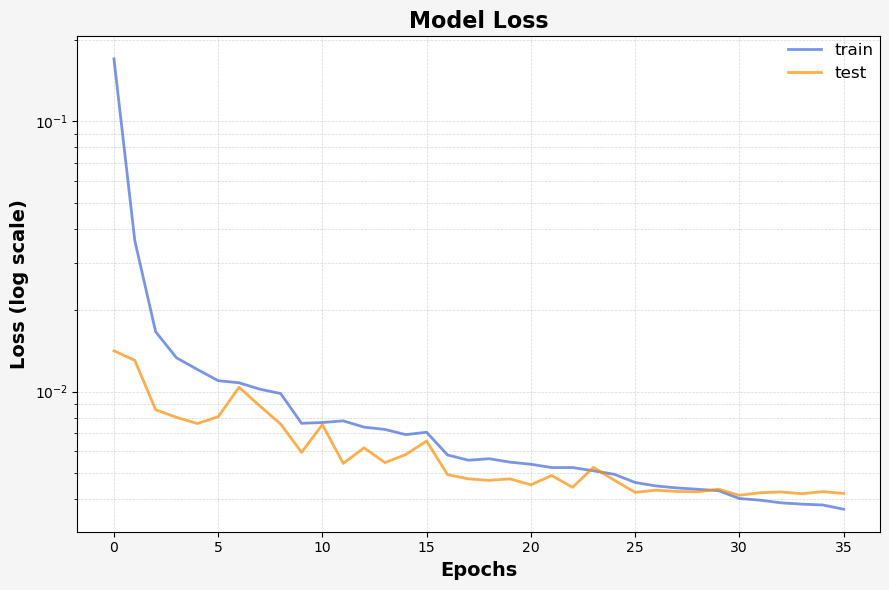

In [48]:
import matplotlib.pyplot as plt

# Access each model's history
model_history = history.history


# Plotting the validation loss for all models
plt.figure(figsize=(9, 6))

# Plot each model's validation loss with smoother lines, subtle markers, and clearer styling
# Training curves (using shades of blue and green)
plt.plot(model_history['loss'], label='train', color='royalblue', linestyle='-', markersize=6, alpha=0.7, linewidth=2)


# Testing curves (using shades of orange and red)
plt.plot(model_history['val_loss'], label='test', color='darkorange', linestyle='-', markersize=6, alpha=0.7, linewidth=2)


# Enhance plot appearance
plt.yscale('log')  # Use logarithmic scale on y-axis
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss (log scale)', fontsize=14, fontweight='bold')
plt.title('Model Loss', fontsize=16, fontweight='bold')

# Refined grid with lighter lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Add legend with better positioning and larger font
plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0., frameon=False)

# Add background color for plot to make it stand out
plt.gcf().set_facecolor('whitesmoke')

# Show plot with a tight layout to avoid clipping
plt.tight_layout()
plt.show()


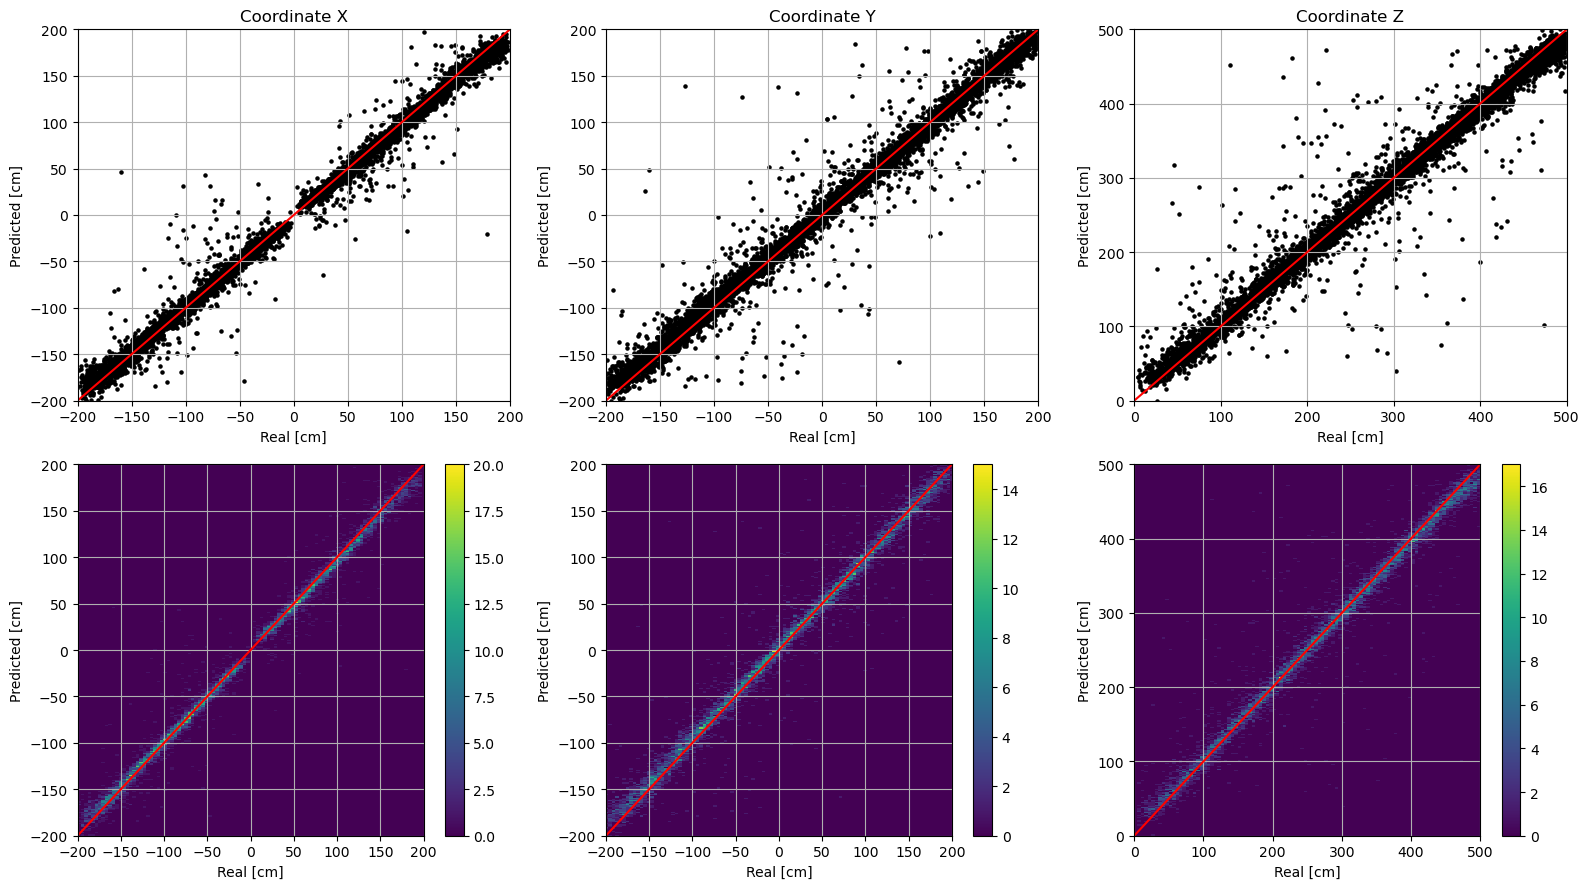

In [49]:
fig, axs = plt.subplots(2,3,figsize=(16,9))



axs[0,0].scatter(y_test_inverse[:,0], y_pred_inverse[:,0], color="black",s=5)
axs[0,0].grid()

axs[0,0].plot([-200,200],[-200,200],color="r")
axs[0,0].title.set_text('Coordinate X')
axs[0,0].set_xlim([-200,200])
axs[0,0].set_ylim([-200,200])
axs[0,0].set_ylabel('Predicted [cm]')
axs[0,0].set_xlabel('Real [cm]')


im1 = axs[1,0].hist2d(y_test_inverse[:,0], y_pred_inverse[:,0].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im1[3], ax=axs[1,0])
axs[1,0].grid()

axs[1,0].plot([-200,200],[-200,200],'r')
axs[1,0].set_xlim([-200,200])
axs[1,0].set_ylim([-200,200])
axs[1,0].set_ylabel('Predicted [cm]')
axs[1,0].set_xlabel('Real [cm]')
axs[1,0].set_facecolor('#440154')


axs[0,1].scatter(y_test_inverse[:,1], y_pred_inverse[:,1], color="black",s=5)
axs[0,1].grid()

axs[0,1].plot([-200,200],[-200,200],color="r")
axs[0,1].title.set_text('Coordinate Y')
axs[0,1].set_xlim([-200,200])
axs[0,1].set_ylim([-200,200])
axs[0,1].set_ylabel('Predicted [cm]')
axs[0,1].set_xlabel('Real [cm]')


im2 = axs[1,1].hist2d(y_test_inverse[:,1], y_pred_inverse[:,1].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im2[3], ax=axs[1,1])
axs[1,1].grid()

axs[1,1].plot([-200,200],[-200,200],'r')
axs[1,1].set_xlim([-200,200])
axs[1,1].set_ylim([-200,200])
axs[1,1].set_ylabel('Predicted [cm]')
axs[1,1].set_xlabel('Real [cm]')
axs[1,1].set_facecolor('#440154')


axs[0,2].scatter(y_test_inverse[:,2], y_pred_inverse[:,2], color="black",s=5)
axs[0,2].grid()

axs[0,2].plot([0,500],[0,500],color="r")
axs[0,2].title.set_text('Coordinate Z')
axs[0,2].set_xlim([0,500])
axs[0,2].set_ylim([0,500])
axs[0,2].set_ylabel('Predicted [cm]')
axs[0,2].set_xlabel('Real [cm]')


im3 = axs[1,2].hist2d(y_test_inverse[:,2], y_pred_inverse[:,2].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im3[3], ax=axs[1,2])
axs[1,2].grid()

axs[1,2].set_xlim([0,500])
axs[1,2].set_ylim([0,500])
axs[1,2].plot([0,500],[0,500], 'r')
axs[1,2].set_ylabel('Predicted [cm]')
axs[1,2].set_xlabel('Real [cm]')
axs[1,2].set_facecolor('#440154')

fig.tight_layout()

plt.show()
#plt.savefig('/tmp/...', dpi=300)

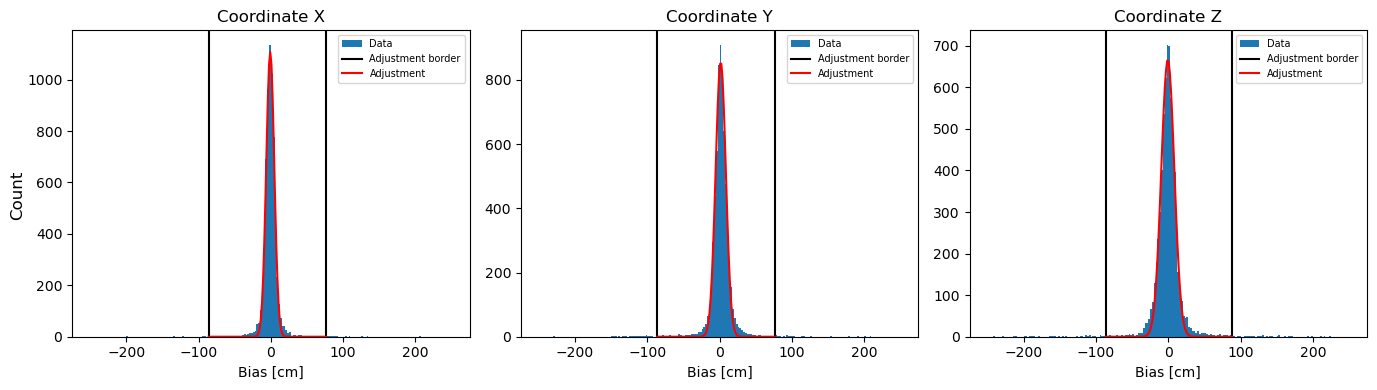

Bias Adjustment variables
------------------
Mean X = -0.90
Sigma X = 5.54
------------------
Mean Y = 1.55
Sigma Y = 7.04
------------------
Mean Z = -0.69
Sigma Z = 9.00
------------------


In [50]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Calculating the differences between the prediction and the real value

diffX = y_pred_inverse[:, 0].flatten() - y_test_inverse[:, 0]
diffY = y_pred_inverse[:, 1].flatten() - y_test_inverse[:, 1]
diffZ = y_pred_inverse[:, 2].flatten() - y_test_inverse[:, 2]

# Create subplots for each coordinate
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# Updated fit_and_plot_hist for nuvT with range [-400, 400]
def fit_and_plot_hist(diff, axs, index, coord_name, ini, fin, hist_range):
    counts, bins, patches = axs[index].hist(diff, 200, range=hist_range, label='Data')
    step = (bins[1] - bins[0]) / 2
    bin_centers = bins[:-1] + step

    # Ensure the fit range is within the histogram bounds
    ini = max(0, min(ini, len(bin_centers) - 1))
    fin = max(ini + 1, min(fin, len(bin_centers) - 1))

    axs[index].axvline(x=bin_centers[ini], color='k', label='Adjustment border')
    axs[index].axvline(x=bin_centers[fin], color='k')

    # Gaussian Fit for the data
    p0 = [np.max(counts), 0, 50]  # Amplitude, mean, sigma (adjust based on your data)
    popt, _ = curve_fit(func, bin_centers[ini:fin+1], counts[ini:fin+1], p0=p0)
    ym = func(np.linspace(bin_centers[ini], bin_centers[fin], 100), *popt)
    axs[index].plot(np.linspace(bin_centers[ini], bin_centers[fin], 100), ym, c='r', label='Adjustment')

    axs[index].set_xlabel('Bias [cm]' if coord_name != 'nuvT' else 'Bias [ns]')  # Set different xlabel for nuvT
    axs[index].set_title(f'Coordinate {coord_name}')
    axs[index].legend(prop={"size": 7})

    return popt

# Call the function with updated range for nuvT

popt_X = fit_and_plot_hist(diffX, axs, 0, 'X', 65, 130, hist_range=[-250, 250])
popt_Y = fit_and_plot_hist(diffY, axs, 1, 'Y', 65, 130, hist_range=[-250, 250])
popt_Z = fit_and_plot_hist(diffZ, axs, 2, 'Z', 65, 135, hist_range=[-250, 250])


# Adjust layout
fig.supylabel('Count')
fig.tight_layout()

# Show the plot
plt.show()

# Print adjustment variables
print('Bias Adjustment variables')
print('------------------')
print(f'Mean X = {popt_X[1]:.2f}')
print(f'Sigma X = {popt_X[2]:.2f}')
print('------------------')
print(f'Mean Y = {popt_Y[1]:.2f}')
print(f'Sigma Y = {popt_Y[2]:.2f}')
print('------------------')
print(f'Mean Z = {popt_Z[1]:.2f}')
print(f'Sigma Z = {popt_Z[2]:.2f}')
print('------------------')


### Save y_pred (dEprom)

In [59]:
print("Test:", y_test_inverse)
print(y_test_inverse.shape)
print("--------------------------")
print("Prediction:", y_pred_inverse)
print(y_pred_inverse.shape)

Test: [[ -76.91663549   71.05214011  465.98515822]
 [ -78.45972196  110.07701994  443.29017568]
 [  26.20121864 -144.52389181  400.0520701 ]
 ...
 [-124.34233789   15.40607009  319.10272126]
 [ 122.74146747   88.72589418  287.34965045]
 [  36.9916876    78.19434956  251.45103767]]
(6620, 3)
--------------------------
Prediction: [[ -69.81183    62.55787   474.1067  ]
 [ -75.96294   117.09481   455.70078 ]
 [  25.50802  -135.30211   386.4632  ]
 ...
 [-126.79511    15.652718  315.07886 ]
 [ 120.58056    88.10604   291.77518 ]
 [  38.76507    74.05219   245.67534 ]]
(6620, 3)


In [57]:
np.save('v0704_y_pred_resnet18.npy', y_pred_inverse)